## Set up

In [1]:
# Basic libraries 
import numpy as np
import pandas as pd
import datetime as dt
import random
from utils import *
from collections import deque

seed = 17
np.random.seed(seed)

# Visualization parameters
%matplotlib notebook
%load_ext autoreload

# Part 5: Training and testing

For the purpose of simplicity, let's create a separate `Testsight` class to hold everything (agent, environment and visualizer) together.

## Main loop

In [2]:
from classes.environment import Environment
from classes.agent import DQNAgent
from classes.visualizer import Visualizer

It's important to note, that I've done some overtime tinkering in these classes, so feel free to check them out.

In [3]:
class Testsight:
    def __init__(self, env_dict, agent_dict, epsilon, epsilon_decay, min_epsilon):
        self.env = Environment(**env_dict) # our environment
        obs = self.env.reset()
        
        agent_dict["action_space_len"] = len(self.env.action_space)
        self.agent = DQNAgent(obs, **agent_dict) # our agent
        
        self.act_to_num = dict(zip(self.env.action_space, np.arange(len(self.env.action_space))))
        self.num_to_act = dict(zip(np.arange(len(self.env.action_space)), self.env.action_space))
        
        self.start_epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.decision_dict = dict(zip(self.env.action_space, [0]*len(self.env.action_space)))
        
    def show(self):
        """
        Visualizes testsight
        """
        self.visualizer = Visualizer(self.env.action_space)
        
    def reset(self):
        """
        Resets testsight to it's default condition
        """
        self.epsilon = self.start_epsilon
        self.episode = 0
        self.train_episode_reward_history = []
        self.train_final_reward_history = []
        self.train_balance_history = []
        self.test_reward_history = []
        self.test_balance_history = []
        self.reset_decision_dict()
        
        obs = self.env.reset()
        self.agent.reset() 
    
    def predict_action(self, state, allowed_actions, test, greedy):
        """
        Predicts an action
        """
        qs = self.agent.get_qs(state, test)
        qs = [q if i in allowed_actions else np.min(qs)-1 for i, q in enumerate(qs)]
        if greedy or test:
            action = np.argmax(qs)
        else:
            div = np.sum(np.exp(qs))
            prob = [np.exp(q)/div for q in qs]
            prob /= sum(prob)
            action = np.random.choice(np.arange(len(qs)), p=prob)
        self.decision_dict[self.num_to_act[action]] +=1
        
        return action
    
    def reset_decision_dict(self):
        self.decision_dict = dict(zip(self.env.action_space, [0]*len(self.env.action_space)))
    
    def get_action(self, state, test, greedy=False):
        """
        Call this to get an action: either a random, or a predicted one, based on the epsilon parameter
        """
        allowed_actions = np.arange(len(self.act_to_num)) 

        if np.random.random() > self.epsilon or test:
            action = self.predict_action(state, allowed_actions, test, greedy=greedy)
            exploration = False
        else: 
            prob = [0.05 if i!=len(allowed_actions)-1 else 1-0.05*(len(allowed_actions)-1) for i, _ in enumerate(allowed_actions)]      
            action = np.random.choice(allowed_actions, p=prob)
            exploration = True
                
        return action, exploration

Now let's fill in the parameters and create a Testsight object.

In [5]:
# Environment dictionary
path_to_1h = data_path + "exp-EURUSD-bars-1h-2016Jan-2020Jan.csv"
path_to_15min = data_path + "exp-EURUSD-bars-m15-2016Jan-2020Jan.csv"
path_to_5min = data_path + "exp-EURUSD-bars-m5-2016Jan-2020Jan.csv"
path_to_1min = data_path + "exp-EURUSD-bars-1m-2016Jan-2020Jan.csv"
paths = (path_to_1h, path_to_15min, path_to_5min, path_to_1min)
timesteps = (24, 32, 32, 64)
funds = 100
episode_length = 1


env_dict = {"paths": paths, "timesteps": timesteps, "max_length": episode_length, "starting_funds": funds,\
            "include_hold_info":False, "from_start_test":True, "mondays_only": False, "multiplier": 10, "goal_balance":105}


# Agent dictionary
discount = 0.975
alpha = 0.005
batch_size = 64
replay_memory_size = 100000
update_target_every = 10

agent_dict = {"discount": discount, "alpha": alpha, "batch_size": batch_size, "update_target_every": update_target_every,\
              "replay_memory_size": replay_memory_size}


# Exploration settings
epsilon = 0.2 # exploration rate
epsilon_decay = 0.985  # exploration decay rate
min_epsilon = 0.01  # minimum exploration rate value

In [6]:
TS = Testsight(env_dict, agent_dict, epsilon, epsilon_decay, min_epsilon)

# Main episode function

In [7]:
def run_episode(ts, pos_mult, per_step_penalty, test):  
    """
    This is the main method which runs a single episode
    """
    ts.reset_decision_dict()
    current_state = ts.env.reset(test)
    start_time = ts.env._current_state.Date
    
    balance_history = []
    reward_history = []
    
    last_reward = 0
    done = False
    step = 0

    episode_reward = 0
    
    ts.visualizer.update_info(test, ts.env._balance, ts.epsilon, last_reward, episode_reward, ts.episode, \
                              start_time, current_time=None)
    ts.visualizer.on_day_start(ts.env.day_df.Date.array, ts.env.day_df.Ask.array)
    
    while not done:
        # Choosing action
        action, exploration = ts.get_action(current_state, test, greedy=True)
        
        # Make a step
        next_state, reward, done, info = ts.env.step(action)  
        balance = ts.env._balance
        
        # Some reward magic happening
        reward = reward - per_step_penalty
        reward = reward*pos_mult if reward > 0 else reward    
        
        
        # Saving history
        last_reward = reward
        episode_reward += reward
        reward_history.append(reward)
        balance_history.append(balance)
        
        # Updating memory and training
        if not test and not exploration:
            ts.agent.update_replay_memory((current_state, action, reward, next_state, done))
        if (step % 10 == 0 or done) and not test:
            ts.agent.train(done)

        # Save next state    
        current_state = next_state    
        step +=1
        
        # Update graps on a new day
        if info["ND"] and not ts.env.day_df.empty and not done:
            ts.visualizer.on_day_start(ts.env.day_df.Date.array, ts.env.day_df.Ask.array)
            if test and balance==100:
                done=True
        
        # Update graphs every 100 steps and on done
        if step % 100 == 0 or done:
            t_df = ts.env.day_df.loc[(ts.env.episode_df.Date.dt.date == ts.env._current_state.Date.date()) &\
                                     (ts.env.episode_df.Date < ts.env._current_state.Date)]
            if not t_df.empty:
                graph_dict = {"balance_h":balance_history, "cur_dates":t_df.Date.array, "cur_prices":t_df.Ask.array,\
                              "decision_dict":ts.decision_dict, "positions":ts.env._open_positions.values(), "test":test}
                
                ts.visualizer.update_graphs(**graph_dict)
                
            ts.visualizer.update_info(test, ts.env._balance, ts.epsilon, last_reward, episode_reward, ts.episode, \
                                start_time, ts.env._current_state.Date)
            
    # Updating history graps
    if test:  
        ts.test_balance_history.append(balance)
        ts.test_reward_history.append(episode_reward)
    else:
        ts.train_balance_history.append(balance)
        ts.train_episode_reward_history.append(episode_reward)
        ts.train_final_reward_history.append(last_reward)   
    ts.visualizer.update_history(ts.train_episode_reward_history, ts.train_final_reward_history, ts.train_balance_history,\
                                 ts.test_reward_history, ts.test_balance_history)
    
    if not test:
        ts.episode +=1
        
    if balance > 100 and test:
        ts.agent.target_model.save_weights("models\\DQNA\\DQNAgent_%d_%.2f.hdf5" % (ts.episode, balance))

    if ts.epsilon > ts.min_epsilon and not test:
        ts.epsilon *= ts.epsilon_decay

# Let's give it a go

##### (these are just some results, not the best ones, just for show)

<IPython.core.display.Javascript object>


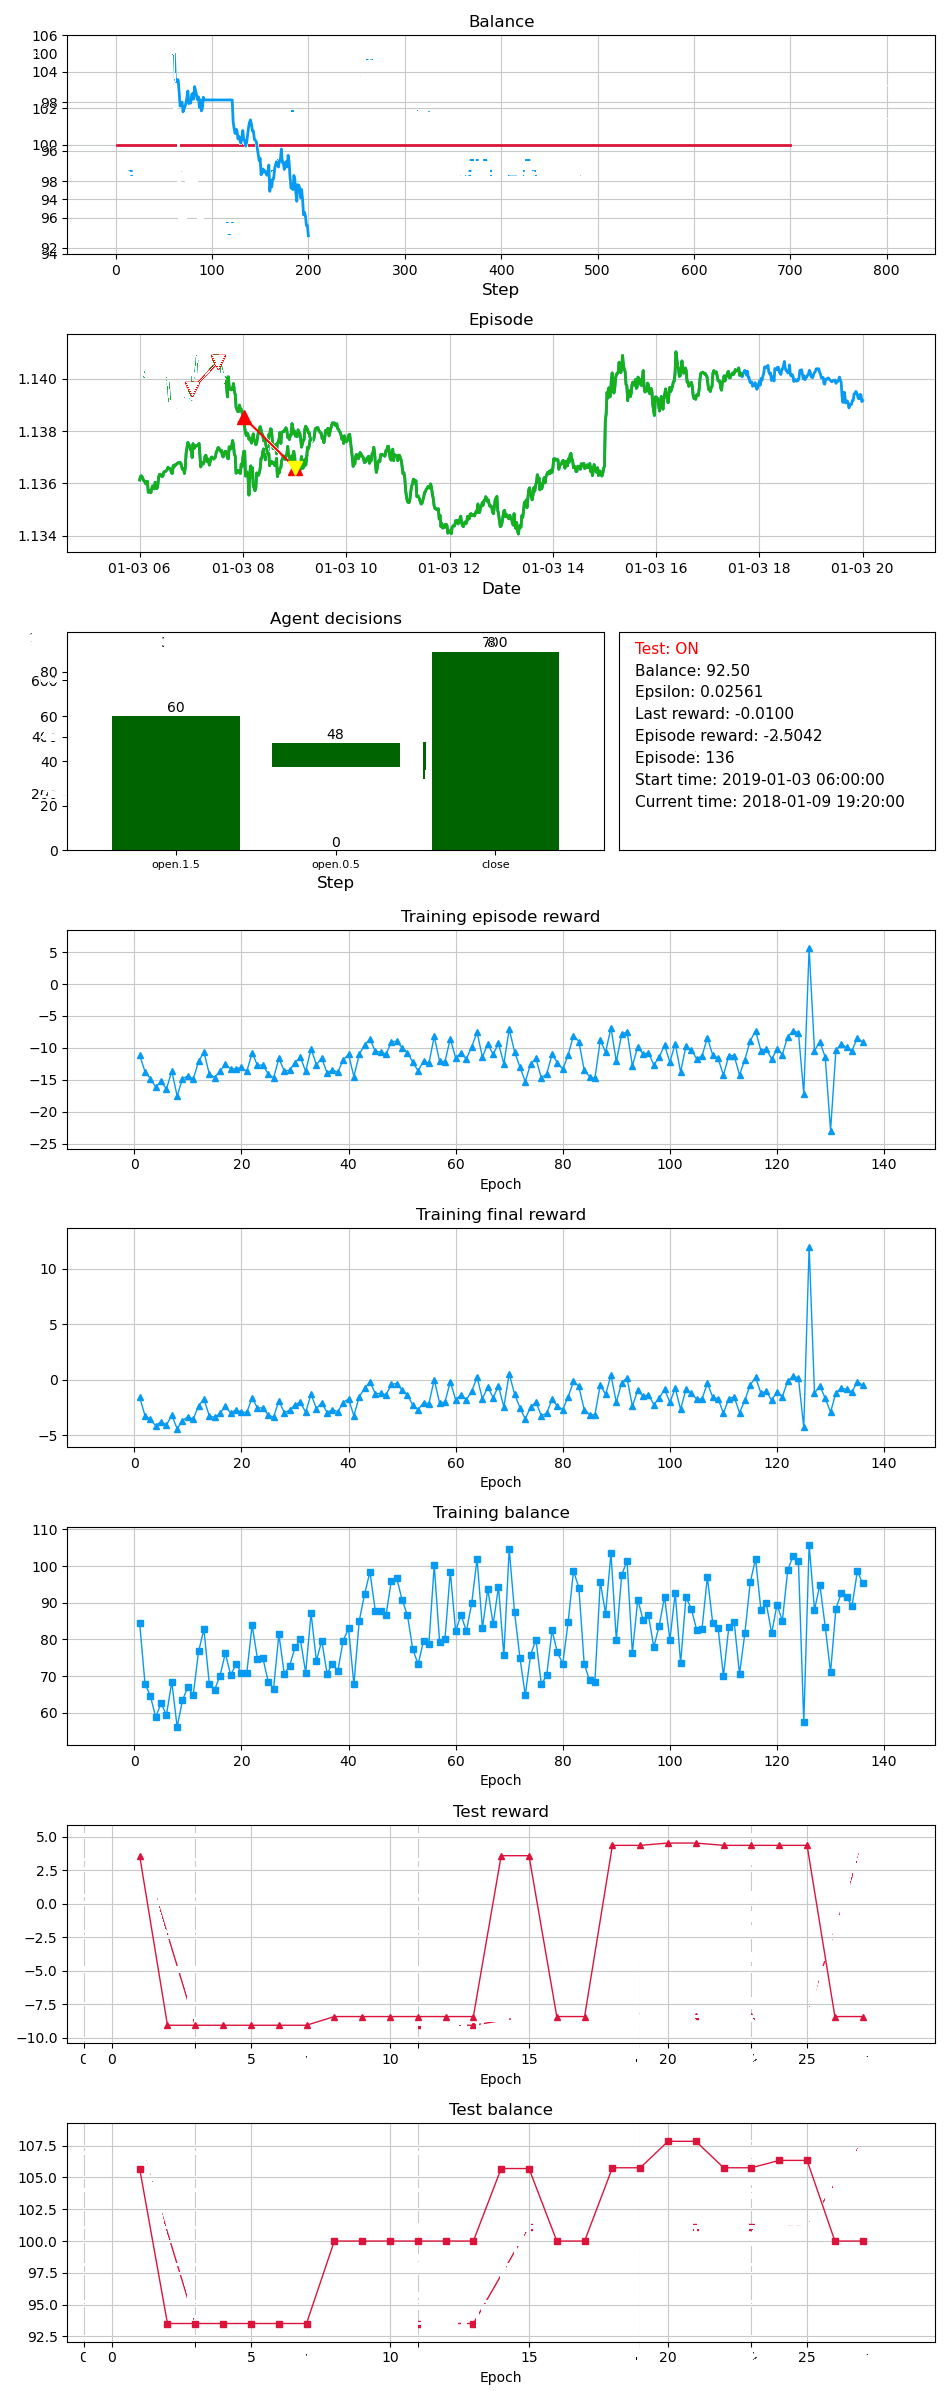

In [ ]:
TS.reset()
TS.show()

episodes = 10000
pos_mult = 1.2

arg_dict = {"ts":TS, "pos_mult": pos_mult, "per_step_penalty": 0.01}
for i in range(episodes):   
    run_episode(**arg_dict, test=False)
    if i%5==0 and i>0:
        run_episode(**arg_dict, test=True)    